In [ ]:
array([[2182,  796],
       [ 839, 2183]])

In [ ]:

cmxs = []

for model in models:

        preds = model.predict(test_examples)
        labels = test_labels

        cmx_non_normal = tf.math.confusion_matrix(labels, preds).numpy() # Create Confusion Matrix
        cmx0 = cmx_non_normal[0] / cmx_non_normal[0].sum()
        cmx1 = cmx_non_normal[1] / cmx_non_normal[1].sum()
        cmx = np.stack((cmx0, cmx1), axis=0)
        cmxs.append(cmx)

plt.figure(figsize=(25,20))
for n in range(len(cmxs)):
    # Plot confusion matrix
    ax = plt.subplot(dim, dim, n+1)
    sns.heatmap(cmxs[n], cmap=['skyblue', 'deepskyblue', 'dodgerblue', 'blue',  'darkblue'])

    # xylabels and title
    plt.title(remove_text_inside_brackets(str(models[n])))
    plt.xlabel('PREDICTIONS')
    plt.ylabel('LABELS')

    # Label ticks
    ax.set_xticklabels(['Background', 'Signal'])
    ax.set_yticklabels(['Background', 'Signal'])
    # Align ticks
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=90, ha="center",
             rotation_mode="anchor")

    # Text Annotations for Blocks in CMX
    for i in range(2):
        for j in range(2):

            value = int(np.round(100*cmxs[n][i, j], 0))

            text = ax.text(j+0.5, 
                           i+0.5, 
                           value,
                           ha="center", 
                           va="center", 
                           color="orangered", 
                           fontsize = 20)
    plt.axis("off")
plt.show()      
print(cmxs)

In [9]:
from FUNCTIONS import *
%matplotlib inline

import sklearn.discriminant_analysis
random.seed(42)

Total Events: 200000
Total Labels: 200000

Shape:  (200000, 1600)

Train:  (139400, 1600) (139400,)
Val:  (30600, 1600) (30600,)
Test:  (30000, 1600) (30000,)
 


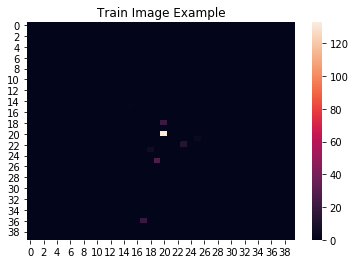

In [10]:
# MAIN
data_s = np.array(pd.read_csv('data/data_s_180k').iloc[:, 1:])
data_b = np.array(pd.read_csv('data/data_b_180k').iloc[:, 1:])

# Slice & Save
events_no = int(100000)
data_s = data_s[0:events_no*40, 0:40]
data_b = data_b[0:events_no*40, 0:40]

# # Save Datasets
# pd.DataFrame(data_s).to_csv('data_s_1000')
# pd.DataFrame(data_b).to_csv('data_b_1000')

train_examples, train_labels, val_examples, val_labels, test_examples, test_labels = preprocess_ML_sklearn(data_s, data_b)




In [11]:
SVM = SVC(random_state=42)

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import time


# SVM
c_parameter = [5]
# Hyperparameters
SVM_parameters = {'C': c_parameter}
# Scoring object using accuracy
scorer = make_scorer(accuracy_score)
clfs_param =[(SVM, SVM_parameters)]

In [13]:
# Create list to store models
models = []
unopt_accuracy = []
accuracies = []

# Perform grid search
for clf, parameter in clfs_param:
    print('\n{}\n'.format(clf.__class__.__name__))
    
    grid_obj = GridSearchCV(clf, parameter, scoring=scorer, n_jobs = -3)
    
    # Perform grid search
    start = time.time()
    grid_fit = grid_obj.fit(train_examples, train_labels)
    end = time.time()
    print('Time to tune: {}s'.format(round(end - start), 2))
    
    # Get best estimator
    best_clf = grid_fit.best_estimator_
    models.append(best_clf)
    
    # Make predictions using the unoptimized and model
    start = time.time()
    predictions = (clf.fit(train_examples, train_labels)).predict(val_examples)
    best_predictions = best_clf.predict(val_examples)
    
    predictions_train = (clf.fit(train_examples, train_labels)).predict(train_examples)
    best_predictions_train = best_clf.predict(train_examples)
    end = time.time()
    print('Time to fit-predict: {}s\n'.format(round(end - start), 2))
    
    # Check hyperparameters
    print('Unoptimised: {}\n'.format(clf.get_params(deep = True)))
    print('Optimised: {}\n'.format(best_clf.get_params(deep = True)))
    
    # Print Results
    print("\nUnoptimised-accuracy-training: {:.4f}".format(accuracy_score(train_labels, predictions_train)))
    print("Optimised-accuracy-training: {:.4f}".format(accuracy_score(train_labels, best_predictions_train)))
    
    print("\nUnoptimised-accuracy-validation: {:.4f}".format(accuracy_score(val_labels, predictions)))
    print("Optimised-accuracy-validation: {:.4f}".format(accuracy_score(val_labels, best_predictions)))
    
    print('\n\n=============================================================================================')
    
    unopt_accuracy.append(accuracy_score(val_labels, predictions))
    accuracies.append(accuracy_score(val_labels, best_predictions))
    
print('All unoptimised accuracy (validation): {}'.format(unopt_accuracy))
print('Best unoptimised accuracy (validation): {}\n'.format(max(unopt_accuracy)))
print('All optimised accuracy (validation): {}'.format(accuracies))
print('Best optimised accuracy (validation): {}'.format(max(accuracies)))


SVC

Time to tune: 57139s
Time to fit-predict: 77590s

Unoptimised: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Optimised: {'C': 5, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Unoptimised-accuracy-training: 0.7488
Optimised-accuracy-training: 0.7703

Unoptimised-accuracy-validation: 0.7380
Optimised-accuracy-validation: 0.7435


All unoptimised accuracy (validation): [0.7380065359477124]
Best unoptimised accuracy (validation): 0.7380065359477124

All optimised accuracy (validation): [0.7435294117647059]
Best optimised accuracy (valid

[SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)]


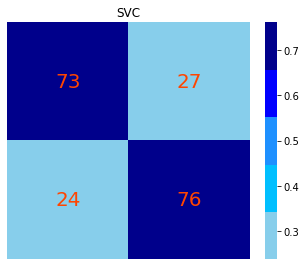

[array([[0.72837462, 0.27162538],
       [0.23829016, 0.76170984]])]


In [14]:
print(models)
cmx_sklearn(models, test_examples, test_labels, dim=4)